# RL assigment - CHIROL Louis

### Imports and agents

Let's first install and import tha packages we need

In [2]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-1k97_xb0
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-1k97_xb0
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 49.0 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.0-py3-none-any.whl size=7808 sha256=0d0ebb00f74288c4bade8b2fa4c2b2abc1a6b107812f3920f5e398309684426a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekuisx

In [3]:
import os
import sys
import gymnasium as gym
import time
import text_flappy_bird_gym
import IPython
from tqdm import tqdm
import numpy as np
import random
from collections import defaultdict
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions import Categorical

from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

RuntimeError: ignored

RuntimeError: ignored

cpu


Now let's define the classes of the agents we will study

In [4]:
# The naive agent with a predefined policy
class NaiveAgent:
    def __init__(self):
        self.Q = {}

        for i in range(-14,0):
          self.Q[i] = 0
        for i in range(0,15):
          self.Q[i] = 1

    def greedy_policy(self, observation):
        return self.Q[observation[1]]


# The Q-learning agent class
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))

    def policy(self, observation):
        # Epsilon-greedy policy to chose an action
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[observation])

    def update(self, observation, action, reward, next_observation):
        # Update of the values
        self.Q[observation][action] += self.alpha * (
            reward + self.gamma * np.max(self.Q[next_observation]) - self.Q[observation][action]
        )

    def update_end(self, observation, action, reward):
        # Last update, after death
        self.Q[observation][action] += self.alpha * (
            reward - self.Q[observation][action]
        )

    def greedy_policy(self, observation):
        # Chose the action with highest value given a state
        return np.argmax(self.Q[observation])

    def load(self, path):
        # Load a saved policy (Q dict)
        with open(path, "rb") as f:
            self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n), pkl.load(f))

    def save(self, path):
        # Save a policy (Q dict)
        with open(path, "wb") as f:
            pkl.dump(dict(self.Q), f)


# The Policy Gradient agent class
class PolicyGradientAgent(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(PolicyGradientAgent, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        # Pass the observation through the NN
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def policy(self, observation):
        # Chose an action to do stochastically for a given state
        observation = torch.from_numpy(np.array(observation)).unsqueeze(0).float().to(device)
        # Compute the probabilities of the actions for this state
        probs = self.forward(observation).cpu()
        # To categorical
        m = Categorical(probs)
        # Sample an action from the probability distribution of the output
        action = m.sample()
        return action.item(), m.log_prob(action)

    def greedy_policy(self, observation):
        # Chose the action with the highest probability for a given state
        observation = torch.from_numpy(np.array(observation)).unsqueeze(0).float().to(device)
        probs = self.forward(observation).cpu()
        return np.argmax(probs.detach().numpy())

    def save(self, path):
        # Save the agent policy (the state dict)
        torch.save(self.state_dict(), path)

    def load(self, path):
        # Load a saved policy (a state dict)
        self.load_state_dict(torch.load(path))


Here we define some helper functions for later (visualization and evaluation)

In [5]:
def monitor_game(env, agent):
    """A function to watch a game in a cmd"""

    obs = env.reset()
    obs = obs[0]
    done = False
    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        obs = next_observation

        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2)  # FPS


def monitor_game_notebook(env, agent):
    """A function to watch a game in a notebook
      Works on Colab, but not on VSCode"""

    obs = env.reset()
    obs = obs[0]
    done = False
    out = display(IPython.display.Pretty(''), display_id=True)

    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        obs = next_observation

        os.system("clear")
        out.update(IPython.display.Pretty(env.render()))
        time.sleep(0.1)  # FPS


def evaluate_score(env, agent, n_episodes=100, disp_tqdm=True, win_thresh=1000):
    """Evaluate the number of wins and score on defeats of a agent over some games"""

    scores = []
    win = 0

    # Display option
    if disp_tqdm:
        iterator = tqdm(range(n_episodes))
    else:
        iterator = range(n_episodes)

    # Loop some episodes
    for _ in iterator:
        obs = env.reset()
        obs = obs[0]
        done = False
        score = 0

        while not done:
            action = agent.greedy_policy(obs)
            next_observation, reward, done, _, info = env.step(action)
            obs = next_observation
            score = info["score"]

            # After a given score, assert the agent beat the game
            if score > win_thresh:
              win += 1
              done = True
              score = np.nan

        scores.append(score)

    return np.nanmean(scores), win

def display_defeat(env, agent):
    """ A function to display the game over screen of an agent"""

    obs = env.reset()
    obs = obs[0]
    done = False
    out = display(IPython.display.Pretty(''), display_id=True)
    
    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        next_observation = next_observation
        obs = next_observation

    os.system("clear")
    print("Defeat ! ")
    out.update(IPython.display.Pretty(env.render()))


def moving_avg(arr, n=5):
  """A moving average function"""

  smoothed = np.zeros(len(arr))
  for i in range(len(arr)-n):
    smoothed[i] = np.mean(arr[i:i+n])
  
  smoothed[len(arr)-n:] = smoothed[len(arr)-n-1]
  return smoothed

### Naive agent
This first part runs our Naive agent.

Run the naive agent and evaluate its score

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = NaiveAgent()

# Evaluate the performance and print the statistics
score, win = evaluate_score(env, agent, n_episodes=100)
print("\n")
print("Average score on defeats: {}".format(score))
print("Win (score>9000): {}%".format(win))
env.close()

100%|██████████| 100/100 [00:00<00:00, 415.18it/s]



Average score on defeats: 21.91
Win (score>9000): 0%


The score is not so bad in average. Let's watch a game:

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = NaiveAgent()
monitor_game_notebook(env, agent)

Text Flappy Bird!
Score: 19
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[            |       ]
[            |       ]
[            |       ]
[  |         |       ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |  *      |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=3)


Let's better understand when he dies, running the next cell several times in a row :

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = NaiveAgent()
display_defeat(env, agent)

Text Flappy Bird!
Score: 3
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[            |       ]
[            |       ]
[            |       ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |         |       ]
[  |  *      |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=4)


Defeat ! 


The agent dies everytime in the same configuration, when he has to idle to much to a low gap. Let's try to build a smarter agent.

### Q-learning on y states
In this section we run a Q-learning agent that sees only the vertical information of the game.

It needs slightly different helper functions and training loop that we define here :

In [ ]:
def train_Qlearning_agent_y(env, agent):
    obs = env.reset()
    obs = obs[0]
    done = False

    while not done:
        action = agent.policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        next_observation = next_observation[1]
        reward = 1 if reward else -1

        if not done:
            agent.update(obs, action, reward, next_observation)
            obs = next_observation
        else:
            agent.update_end(obs, action, reward)


def monitor_game_y(env, agent):
    obs = env.reset()
    obs = obs[0][1]
    done = False
    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        next_observation = next_observation[1]
        obs = next_observation

        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2)  # FPS


def monitor_game_notebook_y(env, agent):
    obs = env.reset()
    obs = obs[0][1]
    done = False
    out = display(IPython.display.Pretty(''), display_id=True)

    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        next_observation = next_observation[1]
        obs = next_observation

        os.system("clear")
        out.update(IPython.display.Pretty(env.render()))
        time.sleep(0.1)  # FPS


def evaluate_score_y(env, agent, n_episodes=100, disp_tqdm=True):
    scores = []
    win = 0

    if disp_tqdm:
      iterator = tqdm(range(n_episodes))
    else : 
      iterator = range(n_episodes)

    for _ in iterator:
        obs = env.reset()
        obs = obs[0][1]
        done = False

        while not done:
            action = agent.greedy_policy(obs)
            next_observation, reward, done, _, info = env.step(action)
            obs = next_observation[1]
            score = info["score"]

            if score > 1000:
              # print("It's over 9.000 !!")
              win += 1
              done = True
              score = np.nan

        scores.append(score)
    return np.nanmean(scores), win


def display_defeat_y(env, agent):
    obs = env.reset()
    obs = obs[0][1]
    done = False
    out = display(IPython.display.Pretty(''), display_id=True)
    
    while not done:
        action = agent.greedy_policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        next_observation = next_observation[1]
        obs = next_observation

    os.system("clear")
    print("Defeat ! ")
    out.update(IPython.display.Pretty(env.render()))

Now let's train it.

Training agent...


100%|██████████| 2500/2500 [00:08<00:00, 283.14it/s]



Agent Q-function:
{(13, 4): array([9.89584468, 2.63723516]), 4: array([9.39480599, 9.90893146]), 6: array([2.93397672, 9.89681228]), 10: array([1.00037377, 0.77998594]), -2: array([8.95444736, 8.56444123]), 0: array([8.68180836, 9.80934257]), 1: array([9.13195755, 9.86478106]), 3: array([7.96988162, 9.93214911]), 7: array([2.24264662, 9.92083072]), -3: array([9.6864955 , 8.91938493]), -1: array([9.27461161, 9.82388859]), -4: array([9.82940647, 9.54243623]), 2: array([6.75237048, 9.93039735]), -5: array([9.89280692, 9.29045184]), (13, -3): array([9.80810533, 1.79644135]), (13, -2): array([9.22697754, 3.81820536]), (13, 2): array([9.88142442, 2.15579106]), 8: array([1.68381021, 0.35904899]), (13, -5): array([9.84198962, 2.5693269 ]), (13, 1): array([9.8818836 , 4.08843672]), (13, -4): array([9.84298268, 2.38385764]), (13, 0): array([9.83170248, 2.62210712]), 5: array([4.70421189, 9.8909459 ]), (13, -1): array([9.83991541, 2.9082294 ]), 9: array([1.06041469, 0.39623515]), (13, 3): array

Text(0, 0.5, 'Score')

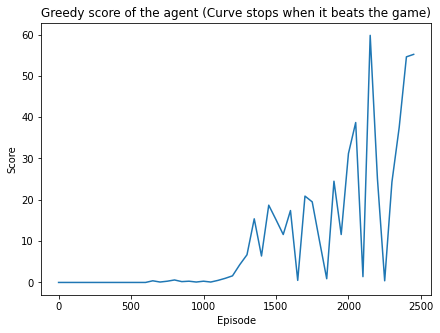

In [ ]:
N = 2500
alpha=0.1
gamma=0.9
epsilon=0.1


print("Training agent...")
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env, alpha, gamma, epsilon)

score_history = []
episodes_history = []

# iterate
for i in tqdm(range(N)):

    # Train over an episode, save the score
    train_Qlearning_agent_y(env, agent)

    # Test every 50 episodes if agent converged
    if i%50 == 0:
      # Test 10 episodes with greedy policy to see if the agent beats the game
      greedy_score, win = evaluate_score_y(env, agent, n_episodes=10, disp_tqdm=False)
      # If agent wins 10 times, stop the learning
      if win==10:
        print("Agent converged !")
        break
      else : 
        score_history.append(greedy_score)
        episodes_history.append(i)

    if i%1000 == 0:
        epsilon/=2
        agent.epsilon = epsilon

env.close()


# Save the agent
agent.save("./Q_learning_agent_y.npy")

print("\n")
print("Agent Q-function:")
print(dict(agent.Q))


# Plot the score history
plt.figure(figsize=(7,5))
plt.plot(episodes_history, score_history)
plt.title("Greedy score of the agent (Curve stops when it beats the game)")
plt.xlabel("Episode")
plt.ylabel("Score")



The score increases with a strong noise, but then stops improving while the agent still did not beat the game. Let's evaluate the performance of the trained agent:

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_y.npy")

score, win = evaluate_score_y(env, agent, n_episodes=100)
print("\n")
print("Average score on defeats: {}".format(score))
print("Win (score>9000): {}%".format(win))
env.close()

100%|██████████| 100/100 [00:00<00:00, 130.65it/s]



Average score on defeats: 38.35
Win (score>9000): 0%


The performance is quite close to the Naive agent, which is quite disappointing. Let's watch a game and some game over screens of this agent to understand why: 

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_y.npy")

# Play game
monitor_game_notebook_y(env, agent)

Text Flappy Bird!
Score: 4
----------------------
[ |         |        ]
[           |        ]
[           |        ]
[           |        ]
[           |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |   *     |        ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=5,dy=3)


In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_y.npy")

# Play game
display_defeat_y(env, agent)

Text Flappy Bird!
Score: 55
----------------------
[ |         |        ]
[           |        ]
[           |        ]
[           |        ]
[           |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |   *     |        ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=5,dy=3)


Defeat ! 


Surprisingly, the Y states Q-learning agent dies in the same configuration as the Naive agent. It seems impossible to solve the game with this information only. The agent falls down too much to catch low holes, and crashes. Let's try another Q-learning agent with the horizontal (x) information, to see if it enables it to do a slower descent towards the lower holes.

### Q-learning on (x,y) states
In this section we run a Q-learning agent that sees the whole information returned by the environment.

Now let's try to apply the Q-learning algorithm, to an agent that gets the whole state (x,y).

Here is the function we will use to train the agent on one episode of the game:

In [ ]:
def train_Qlearning_agent(env, agent, neg_reward=-100):
    obs = env.reset()
    obs = obs[0]
    done = False

    while not done:
        action = agent.policy(obs)
        next_observation, reward, done, _, info = env.step(action)
        reward = 1 if reward else neg_reward

        if not done:
            agent.update(obs, action, reward, next_observation)
            obs = next_observation
        else:
            agent.update_end(obs, action, reward)


Now let's loop over this function to converge towards the optimal state-action values function, and save the agent in a local file to be able to load and use it later.

Training agent...


 49%|████▉     | 12287/25000 [00:31<01:37, 130.72it/s]<ipython-input-4-0af1adbd3c2b>:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
 49%|████▉     | 12300/25000 [00:32<00:33, 374.79it/s]

Agent converged !


{(13, -4): array([9.2595429 , 9.92763053]), (12, -4): array([9.78798682, 4.16890128]), (11, -2): array([9.90003239, 5.86393846]), (10, 2): array([1.59938183, 9.98010513]), (13, -2): array([9.97021463, 9.50994381]), (12, -2): array([9.97577426, 9.8267942 ]), (11, 0): array([9.97605773, 9.90617218]), (10, 4): array([5.82364796, 9.98442683]), (13, -5): array([9.9223216 , 6.23072211]), (12, -5): array([9.93176531, 8.58667416]), (11, -3): array([9.84459632, 7.20642687]), (10, 1): array([4.57367235, 9.95625663]), (13, 2): array([9.86168371, 9.68801852]), (12, 2): array([9.91880416, 8.13857271]), (11, 4): array([4.40790372, 9.95513024]), (10, 8): array([0.99999999, 0.92784257]), (13, 0): array([9.96292055, 8.64128103]), (12, 0): array([8.81878515, 9.97213907]), (11, 2): array([9.72893924, 7.12394932]), (10, 6): array([0.99999999, 9.72612321]), (13, 4): array([3.32393881, 9.97407266]), (12, 4): array([2.65692786, 2.49990118]), (11, 6): array([1.88514558, 0.53875976]), (10, 

Text(0, 0.5, 'Score')

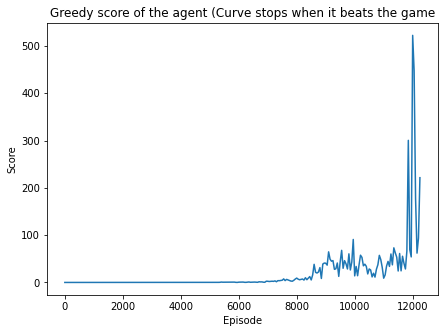

In [ ]:
N = 25000
alpha=0.1
gamma=0.9
epsilon=0.1

# Initialize the agent and the environment
print("Training agent...")
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env, alpha, gamma, epsilon)

score_history = []
episodes_history = []

# iterate
for i in tqdm(range(N)):

    # Train over an episode, save the score
    train_Qlearning_agent(env, agent)

    # Test every 50 episodes if agent converged
    if i%50 == 0:
      # Test 10 episodes with greedy policy to see if the agent beats the game
      greedy_score, win = evaluate_score(env, agent, n_episodes=10, disp_tqdm=False)
      # If agent wins 10 times, stop the learning
      if win==10:
        print("Agent converged !")
        break
      else : 
        score_history.append(greedy_score)
        episodes_history.append(i)

env.close()

print("\n")
print(dict(agent.Q))

# Save the agent
print("Agent Q-function:")
agent.save("./Q_learning_agent_xy.npy")

# Plot the score history
plt.figure(figsize=(7,5))
plt.plot(episodes_history, score_history)
plt.title("Greedy score of the agent (Curve stops when it beats the game")
plt.xlabel("Episode")
plt.ylabel("Score")


The agent "converges" quite fast, that is to say it is quickly able (~10000 training episodes) of reaching high scores in the game. We cannot guarantee that he "beats" the game (it would take forever to prove), but a high score is a good hint it does. At least, it's better than the Naive agent and what a random baseline would do.

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_xy.npy")

score, win = evaluate_score(env, agent, n_episodes=100)
print("\n")
print("Average score on defeats: {}".format(score))
print("Win (score>1000): {}%".format(win))
env.close()

100%|██████████| 100/100 [00:22<00:00,  4.51it/s]



Average score on defeats: nan
Win (score>1000): 100%



<ipython-input-4-f50564a60c62>:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win


This agent systematically gets higher scores than what we consider the threshold to say it beats the game. The Q-learning agent on (x,y) states is a success !

You can run it and watch a game if you want, but you'll have to interrupt it yourself because else it will run forever:

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_xy.npy")

# Play game
monitor_game_notebook(env, agent)

Text Flappy Bird!
Score: 68
----------------------
[       |         |  ]
[       |         |  ]
[      @          |  ]
[                 |  ]
[                    ]
[                    ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-2)


KeyboardInterrupt: ignored

Let's see how he dies (if he dies). You have to interrupt the cell if it takes too long (meaning it won't die).

In [ ]:
# Load the agent
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_xy.npy")

# Play game
display_defeat(env, agent)

Text Flappy Bird!
Score: 16
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[     *   |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=3,dy=3)


Defeat ! 


### Policy Gradient
In this section, we implement another type of agent, based on Policy Gradient and the REINFORCE algorithm.

Now let's try a different algorithm: REINFORCE, relying on policy gradient implemented through Linear Neural layers.

In [6]:
def reinforce(agent, env, optimizer, n_training_episodes, max_t, gamma, print_every=None, disp_tqdm=True, neg_reward=0):
    """This function trains a Policy Gradient agent over n_trainining_episodes, with some
        display parameter and hyperparameters. It returns the score monitoring of the
        agent over the episodes to plot it if desired afterward."""

    rewards_deque = deque(maxlen=100)
    scores_deque = deque(maxlen=100)
    scores = []

    # Iterate over the episodes
    if disp_tqdm:
        iterator = tqdm(range(1, n_training_episodes + 1), desc="Training")
    else:
        iterator = range(1, n_training_episodes + 1)
    for i_episode in iterator:
        # Initialise the episode history and the environment
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]

        # Iterate over the time steps (bounded by max_t)
        for t in range(max_t):
            # Take an action
            action, log_prob = agent.policy(state)
            state, reward, done, _, info = env.step(action)
            reward = 1 if reward else neg_reward

            # Save the log probability and the reward
            saved_log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

        # Save the score
        rewards_deque.append(sum(rewards))
        # scores.append(sum(rewards))
        scores_deque.append(info["score"])
        scores.append(info["score"])

        # Calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        # standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Compute the loss
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if print_every is not None and i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))
            print("Loss: {}".format(policy_loss.item()))

    return scores


def reinforce_evaluate(agent, env, optimizer, n_training_episodes, max_t, gamma, print_every=None, disp_tqdm=True, neg_reward=0):
    """This function is almost the same as above, but performs evaluation of the training agent
    throughout its training loop, to monitor its improvement over time."""

    rewards_deque = deque(maxlen=100)
    scores_deque = deque(maxlen=100)
    scores = []
    episodes = []

    # Iterate over the episodes
    if disp_tqdm:
        iterator = tqdm(range(1, n_training_episodes + 1), desc="Training")
    else:
        iterator = range(1, n_training_episodes + 1)
    for i_episode in iterator:
        # Initialise the episode history and the environment
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]

        # Iterate over the time steps (bounded by max_t)
        for t in range(max_t):
            # Take an action
            action, log_prob = agent.policy(state)
            state, reward, done, _, info = env.step(action)
            reward = reward if reward else neg_reward

            # Save the log probability and the reward
            saved_log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

        # Save the score
        rewards_deque.append(sum(rewards))
        # scores.append(sum(rewards))
        scores_deque.append(info["score"])
        scores.append(info["score"])
        episodes.append(i_episode)

        # Calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        # standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Compute the loss
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if print_every is not None and i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))
            print("Loss: {}".format(policy_loss.item()))


        # Test every 100 episodes if agent converged
        if i_episode%100 == 0:
            # Test 10 episodes with greedy policy to see if the agent beats the game
            greedy_score, win = evaluate_score_reinforce(env, agent, n_episodes=10, disp_tqdm=False)
            # If agent wins 10 times, stop the learning
            if win==10:
                scores += [1000 for j in range(i_episode, n_training_episodes)]
                episodes += [j for j in range(i_episode, n_training_episodes)]
                break

    return scores, episodes


def evaluate_score_reinforce(env, agent, n_episodes=100, disp_tqdm=True):
    """ This function enables to evaluate 
        a policy gradient agent post-training"""

    scores = []
    win = 0

    if disp_tqdm:
        iterator = tqdm(range(n_episodes))
    else:
        iterator = range(n_episodes)
    
    for _ in iterator:
        obs = env.reset()
        obs = obs[0]
        done = False
        score = 0

        while not done:
            action = agent.greedy_policy(obs)
            next_observation, reward, done, _, info = env.step(action)
            obs = next_observation
            score = info["score"]

            if score > 1000:
                win += 1
                done = True
                score = np.nan

        scores.append(score)
    return np.nanmean(scores), win

Now we have all that's needed to run our Policy Gradient agent. Let's train it !

Device: cpu


Training:  21%|██        | 103/500 [00:03<00:19, 20.32it/s]

Episode 100	Average Score: 1.80
Loss: -1.4238147735595703


Training:  40%|████      | 201/500 [00:14<00:40,  7.45it/s]

Episode 200	Average Score: 4.10
Loss: -1.4888114929199219


Training:  60%|██████    | 300/500 [00:31<00:38,  5.25it/s]

Episode 300	Average Score: 8.77
Loss: -1.514095425605774


Training:  80%|████████  | 400/500 [00:57<00:48,  2.08it/s]

Episode 400	Average Score: 29.42
Loss: -4.320761680603027


Training: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]

Episode 500	Average Score: 185.51
Loss: -59.464683532714844
Training completed


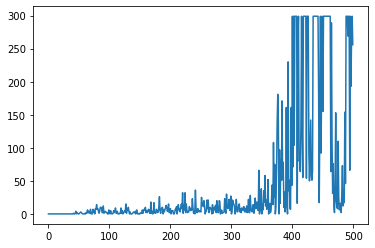

In [7]:
# Hyperparameters
s_size = 2
h_size = 16

n_training_episodes = 500
max_t = 3000
gamma = 0.99
print_every = 100

# Print the device
print("Device: {}".format(device))

# Initialise the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialise the policy
agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-2)

# Train the policy
scores = reinforce(agent, env, optimizer, n_training_episodes, max_t, gamma, print_every)

# Save the policy
agent.save("./policy_gradient_agent.pth")

print("Training completed")

plt.plot(scores)

The agent score increases steadily until it beats the game. It's quite fast to converge. Now we can evaluate it.

In [8]:
# Initialise the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialise the policy
agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)

# Load the policy
agent.load("./policy_gradient_agent.pth")
print("Agent loaded successfully!")

# Evaluate the agent
score, win = evaluate_score_reinforce(env, agent, n_episodes=100)

print("\n")
print("Average score on defeats: {}".format(score))
print("Win (score>9000): {}%".format(win))
env.close()

Agent loaded successfully!


100%|██████████| 100/100 [01:45<00:00,  1.06s/it]



Average score on defeats: 435.32142857142856
Win (score>9000): 72%


Our agent wins every time, which is a good news ! Now we can watch a game (forever) as earlier:

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
agent.load("./agents/policy_gradient_agent.pth")

monitor_game_notebook(env, agent)

Let's see where he dies (if he does): 

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
agent.load("./policy_gradient_agent.pth")

display_defeat(env, agent)

## Experiments
In this section, we use the implementations above to study the impact of the hyperparameters over the performance of our agents.

### Parameters sweep

Learning rate

0it [00:00, ?it/s]<ipython-input-5-e0abc67296cc>:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
5it [01:29, 17.92s/it]
 20%|██        | 1/5 [00:01<00:06,  1.56s/it]

Agent with alpha = 0.1 : score = nan, win = 10


 40%|████      | 2/5 [00:03<00:04,  1.66s/it]

Agent with alpha = 0.3 : score = nan, win = 10


 60%|██████    | 3/5 [00:04<00:03,  1.67s/it]

Agent with alpha = 0.5 : score = nan, win = 10


 80%|████████  | 4/5 [00:06<00:01,  1.64s/it]

Agent with alpha = 0.7 : score = nan, win = 10


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]

Agent with alpha = 1 : score = nan, win = 10


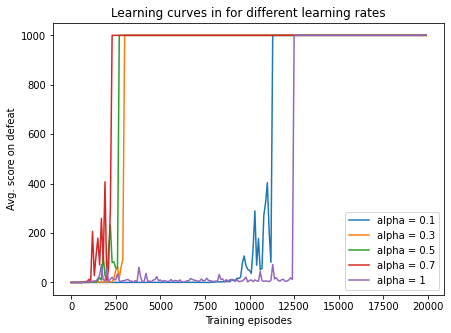

In [ ]:
# Train a Q-learning agent with different hyperparameters alpha
# Plot the score history for each agent
# Compare the performance of the agents

N = 20000
gamma=0.9
epsilon=0.1

alphas = [0.1, 0.3, 0.5, 0.7, 1]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize the agents
agents = []
score_histories = []
episodes_histories = []

for alpha in alphas:
    agent = QLearningAgent(env, alpha, gamma, epsilon)
    agents.append(agent)

# Train the agents
for (i,agent) in tqdm(enumerate(agents)):
    score_history = []
    episodes_history = []

    for i in range(N):
        train_Qlearning_agent(env, agent)
        # Test every 100 episodes if agent converged
        if i%100 == 0:
            # Test 10 episodes with greedy policy to see if the agent beats the game
            greedy_score, win = evaluate_score(env, agent, n_episodes=20, disp_tqdm=False, win_thresh=1000)
            # If agent wins 10 times, stop the learning
            if win==20:
                score_history += [1000 for j in range(i, N, 100)]
                episodes_history += [j for j in range(i, N, 100)]
                break
            else : 
                score_history.append(greedy_score)
                episodes_history.append(i)

    score_histories.append(score_history)
    episodes_histories.append(episodes_history)

# Test the agents
for agent in tqdm(agents):
    score, win = evaluate_score(env, agent, n_episodes=10, disp_tqdm=False)
    print("Agent with alpha = {} :  avg. score on defeat = {}, win rate = {}".format(agent.alpha, score, win/10))

env.close()

# Plot the score history
plt.figure(figsize=(12,7))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, score_history, label="alpha = {}".format(alphas[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different learning rates")
plt.show()

Device: cpu


<ipython-input-28-44cfd1c70615>:94: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Agent with alpha = 0.01 : avg. defeat score = nan, win rate = 1.0


100%|██████████| 10/10 [00:00<00:00, 66.86it/s]


Agent with alpha = 0.05 : avg. defeat score = 8.0, win rate = 0.0


100%|██████████| 10/10 [00:00<00:00, 1003.25it/s]


Agent with alpha = 0.1 : avg. defeat score = 0.0, win rate = 0.0


100%|██████████| 10/10 [00:00<00:00, 367.16it/s]


Agent with alpha = 0.001 : avg. defeat score = 0.0, win rate = 0.0


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Agent with alpha = 0.005 : avg. defeat score = nan, win rate = 1.0


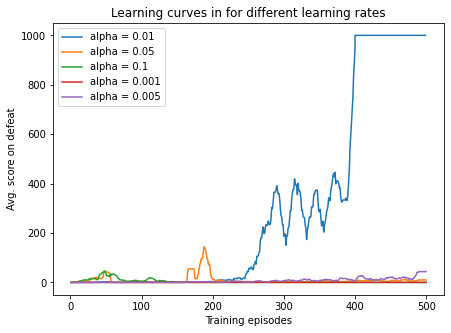

In [ ]:
# Same but with the policy gradient agent

# Hyperparameters
s_size = 2
h_size = 16

n_training_episodes = 500
max_t = 5000
gamma = 0.99

alphas = [0.01, 0.05, 0.1, 0.001, 0.005]

# Print the device
print("Device: {}".format(device))

score_histories = []
episodes_histories = []

for alpha in alphas:
    # Initialise the policy
    agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    optimizer = torch.optim.Adam(agent.parameters(), lr=alpha)

    # Train the policy
    env.reset()
    scores, episodes = reinforce_evaluate(agent, env, optimizer, n_training_episodes, max_t, gamma, disp_tqdm=False)

    # Save the policy
    score_histories.append(scores)
    episodes_histories.append(episodes)

    env.reset()
    score, win = evaluate_score_reinforce(env, agent, n_episodes=10)
    print("Agent with alpha = {} : avg. defeat score = {}, win rate = {}".format(alpha, score, win/10))
    
    agent = None

    env.close()


# Plot the score history
plt.figure(figsize=(7,5))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, moving_avg(score_history, n=10), label="alpha = {}".format(alphas[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different learning rates")
plt.show()

Exploration rate

0it [00:00, ?it/s]<ipython-input-5-e0abc67296cc>:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
6it [01:48, 18.09s/it]
 17%|█▋        | 1/6 [00:01<00:07,  1.48s/it]

Agent with epsilon = 0.05 :  avg. score on defeat = nan, win rate = 1.0


 33%|███▎      | 2/6 [00:03<00:06,  1.51s/it]

Agent with epsilon = 0.1 :  avg. score on defeat = nan, win rate = 1.0


 50%|█████     | 3/6 [00:04<00:04,  1.52s/it]

Agent with epsilon = 0.3 :  avg. score on defeat = nan, win rate = 1.0


 67%|██████▋   | 4/6 [00:06<00:03,  1.69s/it]

Agent with epsilon = 0.5 :  avg. score on defeat = nan, win rate = 1.0


 83%|████████▎ | 5/6 [00:07<00:01,  1.62s/it]

Agent with epsilon = 0.7 :  avg. score on defeat = nan, win rate = 1.0


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]

Agent with epsilon = 0.9 :  avg. score on defeat = nan, win rate = 1.0


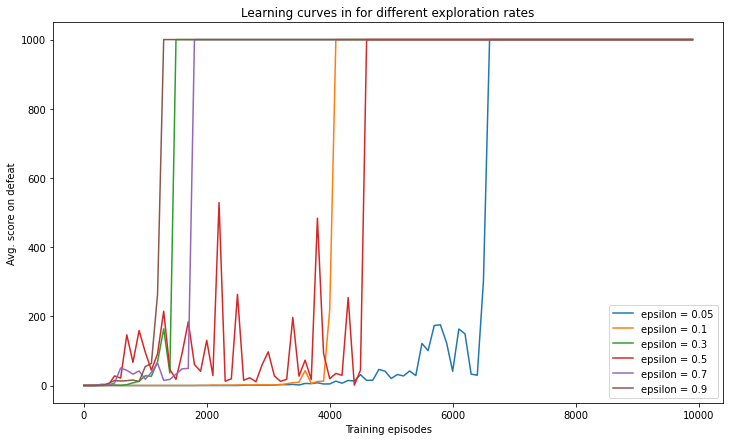

In [ ]:
# Train a Q-learning agent with different hyperparameters epsilon
# Plot the score history for each agent
# Compare the performance of the agents

N = 10000
gamma=0.9
alpha = 0.3

epsilons = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize the agents
agents = []
score_histories = []
episodes_histories = []

for epsilon in epsilons:
    agent = QLearningAgent(env, alpha, gamma, epsilon)
    agents.append(agent)

# Train the agents
for (i,agent) in tqdm(enumerate(agents)):
    score_history = []
    episodes_history = []

    for i in range(N):
        train_Qlearning_agent(env, agent)
            # Test every 50 episodes if agent converged
        if i%100 == 0:
            # Test 10 episodes with greedy policy to see if the agent beats the game
            greedy_score, win = evaluate_score(env, agent, n_episodes=20, disp_tqdm=False, win_thresh=1000)
            # If agent wins 10 times, stop the learning
            if win==20:
                score_history += [1000 for j in range(i, N, 100)]
                episodes_history += [j for j in range(i, N, 100)]
                break
            else : 
                score_history.append(greedy_score)
                episodes_history.append(i)

    score_histories.append(score_history)
    episodes_histories.append(episodes_history)

# Test the agents
for agent in tqdm(agents):
    score, win = evaluate_score(env, agent, n_episodes=10, disp_tqdm=False)
    print("Agent with epsilon = {} :  avg. score on defeat = {}, win rate = {}".format(agent.epsilon, score, win/10))

env.close()

# Plot the score history
plt.figure(figsize=(12,7))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, score_history, label="epsilon = {}".format(epsilons[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different exploration rates")
plt.show()

Discount rate

0it [00:00, ?it/s]<ipython-input-5-e0abc67296cc>:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
6it [01:32, 15.35s/it]
 17%|█▋        | 1/6 [00:02<00:10,  2.13s/it]

Agent with gamma = 0.1 :  avg. score on defeat = nan, win rate = 1.0


 33%|███▎      | 2/6 [00:04<00:08,  2.05s/it]

Agent with gamma = 0.3 :  avg. score on defeat = nan, win rate = 1.0


 50%|█████     | 3/6 [00:05<00:05,  1.90s/it]

Agent with gamma = 0.5 :  avg. score on defeat = nan, win rate = 1.0


 67%|██████▋   | 4/6 [00:07<00:03,  1.78s/it]

Agent with gamma = 0.7 :  avg. score on defeat = nan, win rate = 1.0


 83%|████████▎ | 5/6 [00:09<00:01,  1.76s/it]

Agent with gamma = 0.99 :  avg. score on defeat = nan, win rate = 1.0


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]

Agent with gamma = 1 :  avg. score on defeat = nan, win rate = 1.0


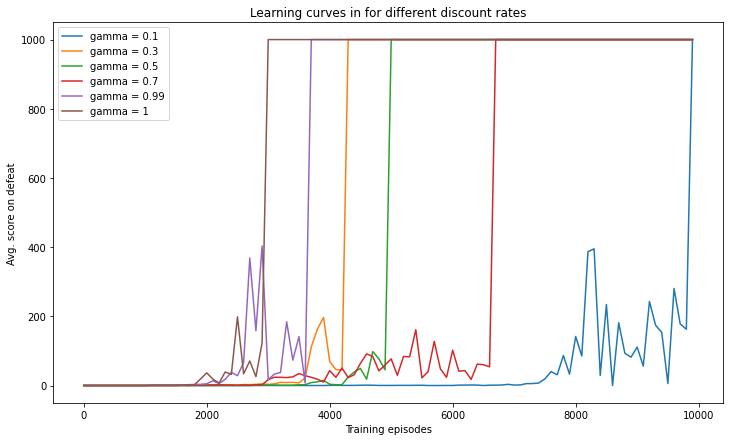

In [ ]:
# Train a Q-learning agent with different hyperparameters gammas
# Plot the score history for each agent
# Compare the performance of the agents

N = 10000
alpha = 0.3
epsilon = 0.1

gammas = [0.1, 0.3, 0.5, 0.7, 0.99, 1]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize the agents
agents = []
score_histories = []
episodes_histories = []

for gamma in gammas:
    agent = QLearningAgent(env, alpha, gamma, epsilon)
    agents.append(agent)

# Train the agents
for (i,agent) in tqdm(enumerate(agents)):
    score_history = []
    episodes_history = []

    for i in range(N):
        train_Qlearning_agent(env, agent)
            # Test every 50 episodes if agent converged
        if i%100 == 0:
            # Test 10 episodes with greedy policy to see if the agent beats the game
            greedy_score, win = evaluate_score(env, agent, n_episodes=20, disp_tqdm=False, win_thresh=1000)
            # If agent wins 10 times, stop the learning
            if win==20:
                score_history += [1000 for j in range(i, N, 100)]
                episodes_history += [j for j in range(i, N, 100)]
                break
            else : 
                score_history.append(greedy_score)
                episodes_history.append(i)

    score_histories.append(score_history)
    episodes_histories.append(episodes_history)

# Test the agents
for agent in tqdm(agents):
    score, win = evaluate_score(env, agent, n_episodes=10, disp_tqdm=False)
    print("Agent with gamma = {} :  avg. score on defeat = {}, win rate = {}".format(agent.gamma, score, win/10))

env.close()

# Plot the score history
plt.figure(figsize=(12,7))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, score_history, label="gamma = {}".format(gammas[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different discount rates")
plt.show()

In [ ]:
# Same but with the policy gradient agent

# Hyperparameters
s_size = 2
h_size = 16

n_training_episodes = 500
max_t = 1000
alpha = 0.01

gammas = [0.1, 0.3, 0.5, 0.7, 0.99, 1]


# Print the device
print("Device: {}".format(device))

score_histories = []
episodes_histories = []

for gamma in gammas:
    # Initialise the policy
    agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    optimizer = torch.optim.Adam(agent.parameters(), lr=alpha)

    # Train the policy
    env.reset()
    scores, episodes = reinforce_evaluate(agent, env, optimizer, n_training_episodes, max_t, gamma, disp_tqdm=False)

    # Save the policy
    score_histories.append(scores)
    episodes_histories.append(episodes)

    env.reset()
    score, win = evaluate_score_reinforce(env, agent, n_episodes=10)
    print("Agent with gamma = {} : avg. defeat score = {}, win rate = {}".format(gamma, score, win/10))
    
    agent = None
    
    env.close()

Device: cpu


<ipython-input-28-44cfd1c70615>:94: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Agent with gamma = 0.1 : avg. defeat score = nan, win rate = 1.0


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Agent with gamma = 0.3 : avg. defeat score = 437.57142857142856, win rate = 0.3


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Agent with gamma = 0.5 : avg. defeat score = nan, win rate = 1.0


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Agent with gamma = 0.7 : avg. defeat score = 451.4, win rate = 0.0


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]

Agent with gamma = 0.99 : avg. defeat score = nan, win rate = 1.0


RuntimeError: ignored

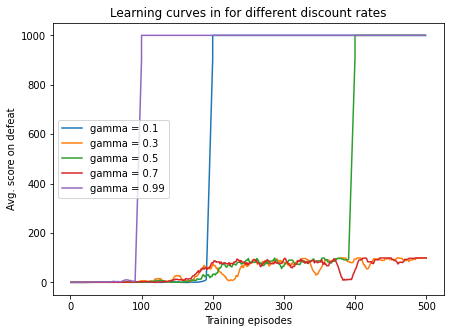

In [ ]:
# Plot the score history
plt.figure(figsize=(7,5))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, moving_avg(score_history, n=10), label="gamma = {}".format(gammas[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different discount rates")
plt.show()

Negative reward

0it [00:00, ?it/s]<ipython-input-4-e0abc67296cc>:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
1it [00:38, 38.04s/it]

Agent with neg. reward = 0 :  avg. score on defeat = nan, win rate = 1.0


2it [00:56, 26.23s/it]

Agent with neg. reward = -1 :  avg. score on defeat = nan, win rate = 1.0


3it [01:07, 19.54s/it]

Agent with neg. reward = -10 :  avg. score on defeat = nan, win rate = 1.0


4it [01:31, 21.42s/it]

Agent with neg. reward = -100 :  avg. score on defeat = nan, win rate = 1.0


5it [01:43, 20.61s/it]

Agent with neg. reward = -1000 :  avg. score on defeat = nan, win rate = 1.0


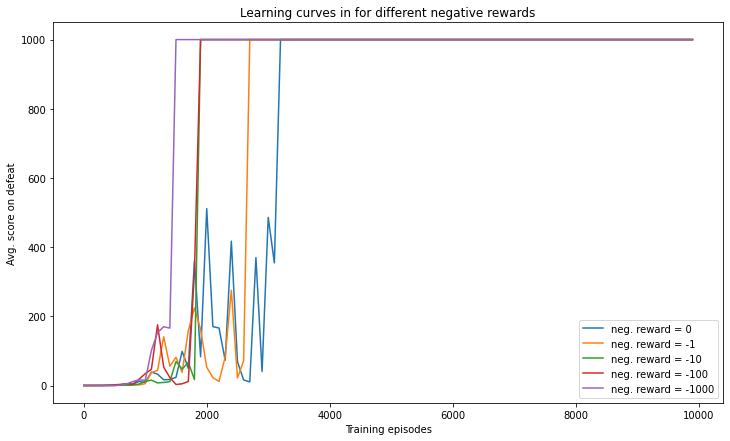

In [ ]:
# Train a Q-learning agent with different hyperparameters alpha
# Plot the score history for each agent
# Compare the performance of the agents

N = 10000
gamma=0.9
alpha = 0.3
epsilon = 0.3

neg_rewards = [0, -1, -10, -100, -1000]

# Initialize the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize the agents
score_histories = []
episodes_histories = []

for i, neg_reward in tqdm(enumerate(neg_rewards)):

    agent = QLearningAgent(env, alpha, gamma, epsilon)
    
    # Train the agents
    score_history = []
    episodes_history = []

    for i in range(N):
        train_Qlearning_agent(env, agent, neg_reward=neg_reward)
            # Test every 50 episodes if agent converged
        if i%100 == 0:
            # Test 10 episodes with greedy policy to see if the agent beats the game
            greedy_score, win = evaluate_score(env, agent, n_episodes=20, disp_tqdm=False, win_thresh=1000)
            # If agent wins 10 times, stop the learning
            if win==20:
                score_history += [1000 for j in range(i, N, 100)]
                episodes_history += [j for j in range(i, N, 100)]
                break
            else : 
                score_history.append(greedy_score)
                episodes_history.append(i)

    score_histories.append(score_history)
    episodes_histories.append(episodes_history)

    score, win = evaluate_score(env, agent, n_episodes=10, disp_tqdm=False)
    print("Agent with neg. reward = {} :  avg. score on defeat = {}, win rate = {}".format(neg_reward, score, win/10))

env.close()

# Plot the score history
plt.figure(figsize=(12,7))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, score_history, label="neg. reward = {}".format(neg_rewards[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different negative rewards")
plt.show()

Device: cpu


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Agent with neg. reward = 0 : avg. defeat score = 521.7142857142857, win rate = 0.3


<ipython-input-61-993d441671db>:177: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores), win
100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Agent with neg. reward = -1 : avg. defeat score = nan, win rate = 1.0


100%|██████████| 10/10 [00:00<00:00, 10.60it/s]


Agent with neg. reward = -10 : avg. defeat score = 80.6, win rate = 0.0


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Agent with neg. reward = -100 : avg. defeat score = nan, win rate = 1.0


100%|██████████| 10/10 [00:00<00:00, 27.04it/s]


Agent with neg. reward = -1000 : avg. defeat score = 28.8, win rate = 0.0


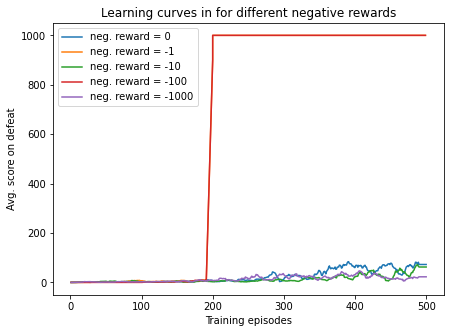

In [ ]:
# Same but with the policy gradient agent

# Hyperparameters
s_size = 2
h_size = 16

n_training_episodes = 500
max_t = 1000
alpha = 0.01
gamma = 0.99

neg_rewards = [0, -1, -10, -100, -1000]

# Print the device
print("Device: {}".format(device))

score_histories = []
episodes_histories = []

for neg_reward in neg_rewards:
    # Initialise the policy
    agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    optimizer = torch.optim.Adam(agent.parameters(), lr=alpha)

    # Train the policy
    env.reset()
    scores, episodes = reinforce_evaluate(agent, env, optimizer, n_training_episodes, max_t, gamma, disp_tqdm=False, neg_reward=neg_reward)

    # Save the policy
    score_histories.append(scores)
    episodes_histories.append(episodes)

    env.reset()
    score, win = evaluate_score_reinforce(env, agent, n_episodes=10)
    print("Agent with neg. reward = {} : avg. defeat score = {}, win rate = {}".format(neg_reward, score, win/10))
    
    agent = None
    env.close()


# Plot the score history
plt.figure(figsize=(7,5))
for (i, (episode_history, score_history)) in enumerate(zip(episodes_histories, score_histories)):
    plt.plot(episode_history, moving_avg(score_history, n=10), label="neg. reward = {}".format(neg_rewards[i]))
plt.legend()
plt.xlabel("Training episodes")
plt.ylabel("Avg. score on defeat")
plt.title("Learning curves in for different negative rewards")
plt.show()



### Plot the Q function

#### Q-learning

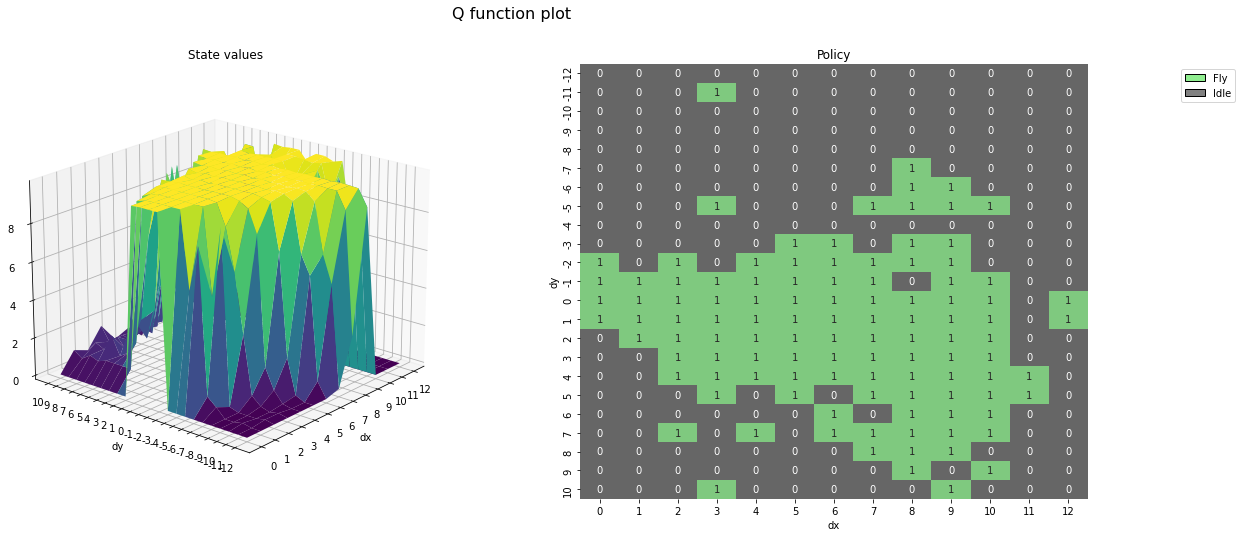

In [ ]:
def create_grids(agent):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.Q.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    dx, dy = np.meshgrid(
        # dx, dy
        np.arange(0, 13),
        np.arange(-12, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([dx, dy]),
    )
    value_grid = dx, dy, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([dx, dy]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    dx, dy, value = value_grid
    # fig = plt.figure(figsize=plt.figaspect(0.4))
    fig = plt.figure(figsize=(20,8))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        dx,
        dy,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0, 13), range(0, 13))
    plt.yticks(range(-12, 11), range(-12, 11))
    ax1.set_title("State values")
    ax1.set_xlabel("dx")
    ax1.set_ylabel("dy")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False,
                      xticklabels=range(0,13), yticklabels=range(-12,11))
    ax2.set_title("Policy")
    ax2.set_xlabel("dx")
    ax2.set_ylabel("dy")

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Fly"),
        Patch(facecolor="grey", edgecolor="black", label="Idle"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# Load the agent
agent = QLearningAgent(env)
agent.load("./Q_learning_agent_xy.npy")


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent)
fig1 = create_plots(value_grid, policy_grid, title="Q function plot")
plt.show()

#### Policy Gradient

Agent loaded successfully!


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


{(4, 4): array([ 0., 17.]), (5, 5): array([ 0., 17.]), (6, 6): array([ 0., 17.]), (7, 7): array([ 0., 17.]), (8, 8): array([ 0., 17.]), (9, 9): array([ 0., 17.]), (0, -1): array([523.,  76.]), (1, -2): array([631.,   0.]), (2, -1): array([  0., 262.]), (3, -4): array([488.,   0.]), (4, -5): array([368.,   0.]), (5, -4): array([  0., 209.]), (6, -3): array([  0., 184.]), (7, -2): array([  0., 172.]), (8, -1): array([  0., 172.]), (9, 0): array([  0., 172.]), (0, 0): array([  1., 401.]), (1, -3): array([803.,   0.]), (2, -4): array([430.,   0.]), (3, -3): array([160., 437.]), (4, -2): array([  0., 295.]), (5, -5): array([394.,   1.]), (6, -6): array([241.,   0.]), (7, -5): array([  0., 147.]), (8, -8): array([80.,  0.]), (9, -9): array([30.,  0.]), (1, 0): array([  0., 337.]), (2, -3): array([681.,   0.]), (4, -3): array([  0., 360.]), (5, -2): array([  0., 171.]), (6, -1): array([  0., 171.]), (7, 0): array([  0., 171.]), (8, 1): array([  0., 171.]), (9, 2): array([  0., 171.]), (0, -2)

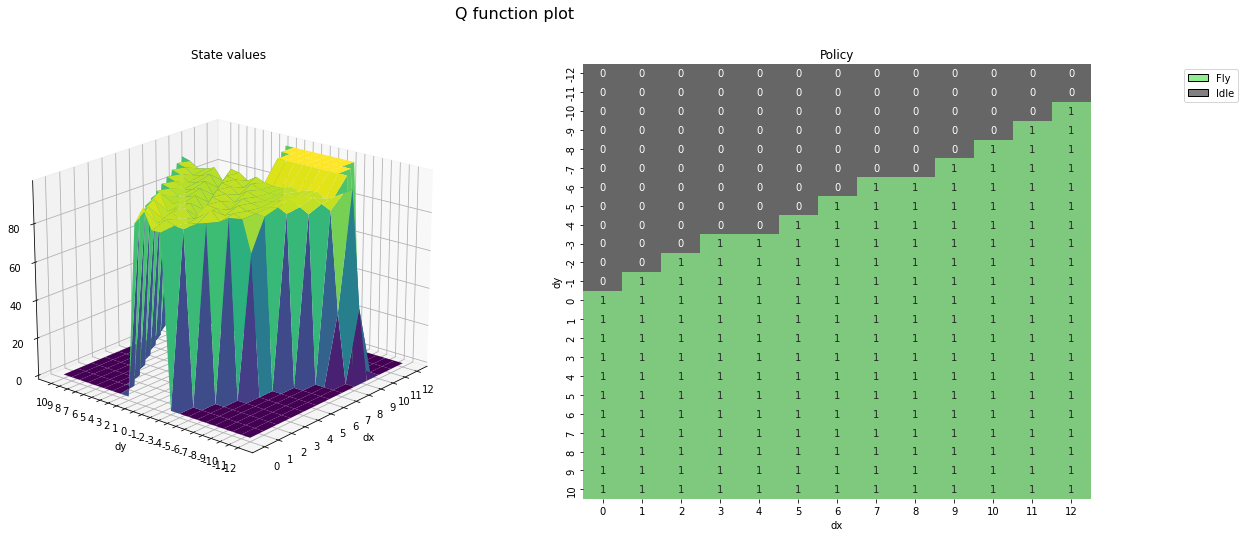

In [55]:
import numpy as np

def mc_Q_estimation(agent, env, num_episodes, gamma=1.0, max_t=1000):
    """
    Estimate the state-action values function Q with Monte-Carlo method.
    
    Args:
    - policy: a function that takes in a state and returns a probability distribution over actions
    - env: an environment with which to interact and sample episodes
    - num_episodes: the number of episodes to sample
    - gamma: the discount factor
    
    Returns:
    - Q: an array of shape (num_states, num_actions) containing the estimated state-action values
    """
    num_states = len(env.observation_space)
    num_actions = env.action_space.n
    # returns = np.zeros((num_states, num_actions))
    # counts = np.zeros((num_states, num_actions))
    returns = defaultdict(lambda: np.zeros(env.action_space.n))
    counts = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i in tqdm(range(num_episodes)):
        episode = []
        state = env.reset()[0]
        done = False
        t = 0

        while not done and t<max_t:
            action, log_prob = agent.policy(state)
            next_observation, reward, done, _, info = env.step(action)
            episode.append((state, action, reward))
            state = next_observation
            t+=1
        
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            # print(state,action)
            returns[state][action] += G
            counts[state][action] += 1

    print(dict(counts))
    print(dict(returns))

    for state in list(dict(counts).keys()):
        for action in range(num_actions):
            if counts[state][action] > 0:
                Q[state][action] = returns[state][action] / counts[state][action]
    
    Q = dict(Q)
    returns = dict(returns)
    counts = dict(counts)

    return Q, counts, returns

def create_grids_reinforce(agent, Q):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)

    for obs, action_values in Q.items():
        state_value[obs] = float(np.max(action_values))

    dx, dy = np.meshgrid(
        # dx, dy
        np.arange(0, 13),
        np.arange(-12, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([dx, dy]),
    )
    value_grid = dx, dy, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: agent.greedy_policy(tuple(obs)),
        axis=2,
        arr=np.dstack([dx, dy]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    dx, dy, value = value_grid
    # fig = plt.figure(figsize=plt.figaspect(0.4))
    fig = plt.figure(figsize=(20,8))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        dx,
        dy,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0, 13), range(0, 13))
    plt.yticks(range(-12, 11), range(-12, 11))
    ax1.set_title("State values")
    ax1.set_xlabel("dx")
    ax1.set_ylabel("dy")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False,
                      xticklabels=range(0,13), yticklabels=range(-12,11))
    ax2.set_title("Policy")
    ax2.set_xlabel("dx")
    ax2.set_ylabel("dy")

    # add a legend
    legend_elements = [
                      Patch(facecolor="lightgreen", edgecolor="black", label="Fly"),
                      Patch(facecolor="grey", edgecolor="black", label="Idle"),
                      ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# Initialise the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialise the policy
agent = PolicyGradientAgent(s_size, env.action_space.n, h_size).to(device)

# Load the policy
agent.load("./policy_gradient_agent.pth")
print("Agent loaded successfully!")

Q, counts, returns = mc_Q_estimation(agent, env, num_episodes=10, gamma=0.99)

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_reinforce(agent, Q)
fig1 = create_plots(value_grid, policy_grid, title="Q function plot")
plt.show()